<a href="https://colab.research.google.com/github/freitasigoor/bootcamp_Train/blob/main/bootcamp_110525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:

import numpy as np


import seaborn as sns

# Pré-processamento e modelagem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, hamming_loss

In [ ]:

data_path = '/content/drive/MyDrive/trabalho/'


import pandas as pd

# Leitura dos arquivos
df_train = pd.read_csv(data_path + 'bootcamp_train.csv')
df_test  = pd.read_csv(data_path + 'bootcamp_test.csv')

# Exibição das primeiras linhas
df_train.head()

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
0,0,154,169.0,260124,260136,100,75,27,17,9948.0,...,362.000,3.068,125,FALSE,0,False,FALSE,não,False,Sim
1,1,1121,-186.0,1789332,1789337,100,-206,9,-194,2240.0,...,294.000,1.441,115,FALSE,FALSE,False,TRUE,Não,False,Não
2,2,41,216.0,2708878,2708939,100,6298,275,134,654634.0,...,-1.879,1.000,42,FALSE,FALSE,True,FALSE,não,False,Não
3,3,129,157.0,86408,86427,100,276,39,26,33858.0,...,-416.000,8.223,115,FALSE,FALSE,True,FALSE,não,False,Não
4,4,436,442.0,4959398,530985,100,63,17,17,6374.0,...,-2.096,2.083,90,FALSE,TRUE,False,FALSE,Não,False,Não


In [ ]:
print(df_train.info())
print(df_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3390 non-null   int64  
 1   x_minimo                      3390 non-null   int64  
 2   x_maximo                      3334 non-null   float64
 3   y_minimo                      3390 non-null   int64  
 4   y_maximo                      3390 non-null   int64  
 5   peso_da_placa                 3390 non-null   int64  
 6   area_pixels                   3390 non-null   int64  
 7   perimetro_x                   3390 non-null   int64  
 8   perimetro_y                   3390 non-null   int64  
 9   soma_da_luminosidade          3290 non-null   float64
 10  maximo_da_luminosidade        3292 non-null   float64
 11  comprimento_do_transportador  3390 non-null   int64  
 12  tipo_do_aço_A300              3390 non-null   object 
 13  tip

In [ ]:
# 1) Separe colunas numéricas e categóricas
num_cols = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object','bool']).columns.tolist()

# Remove 'id' from num_cols instead of cat_cols
num_cols.remove('id')  # id não é feature

# Get common categorical columns between train and test
common_cat_cols = list(set(cat_cols) & set(df_test.columns))


# 2) Preenchimento
from sklearn.impute import SimpleImputer

# numéricos → mediana
imp_num = SimpleImputer(strategy='median')
df_train[num_cols] = imp_num.fit_transform(df_train[num_cols])
df_test[num_cols]  = imp_num.transform(df_test[num_cols])

# categóricos → mais frequente
imp_cat = SimpleImputer(strategy='most_frequent')
#Fit and transform using only the common cat_cols to avoid key error
df_train[common_cat_cols] = imp_cat.fit_transform(df_train[common_cat_cols])
df_test[common_cat_cols]  = imp_cat.transform(df_test[common_cat_cols])

In [ ]:
# Mapear todos os object/bool para 0/1
for col in cat_cols:

    if col in df_test.columns:
        # padroniza strings
        df_train[col] = df_train[col].astype(str).str.lower()
        df_test[col]  = df_test[col].astype(str).str.lower()
        # mapeia valores típicos de sim/não/true/false
        df_train[col] = df_train[col].map({'true':1,'false':0,'sim':1,'não':0,'nao':0})
        df_test[col]  = df_test[col].map({'true':1,'false':0,'sim':1,'não':0,'nao':0})

In [ ]:
# colunas de rótulo
target_cols = ['falha_1','falha_2','falha_3','falha_4','falha_5','falha_6','falha_outros']

# X: remove id e targets
X = df_train.drop(columns=['id'] + target_cols)
# y: apenas as colunas de falhas (já estão em 0/1)
y = df_train[target_cols]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Também escalona o teste
X_test = df_test.drop(columns=['id'])
X_test_scaled = scaler.transform(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
from sklearn.model_selection import train_test_split

# Split aleatório sem stratify
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


Etapa 5: Treinamento do Modelo Multirrótulo

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# 1) Definir targets
target_cols = ['falha_1','falha_2','falha_3','falha_4','falha_5','falha_6','falha_outros']

# 2) Em X, remova id+targets e mantenha só as colunas numéricas
X = df_train.drop(columns=['id'] + target_cols).select_dtypes(include=[np.number])
X_test = df_test.drop(columns=['id']).select_dtypes(include=[np.number])

# 3) Imputar mediana nas features numéricas
imp = SimpleImputer(strategy='median')
X_imp   = imp.fit_transform(X)
X_test_imp = imp.transform(X_test)

# 4) Escalonar
scaler = StandardScaler()
X_scaled      = scaler.fit_transform(X_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 5) Split treino/validação (aleatório, sem stratify)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, df_train[target_cols],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

imp_y = SimpleImputer(strategy='most_frequent')
y_train = imp_y.fit_transform(y_train)
y_val = imp_y.transform(y_val)

base_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)
clf = OneVsRestClassifier(base_clf)
clf.fit(X_train, y_train)

print("✔️ Modelo treinado com sucesso!")


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tipo_do_aço_A300' 'tipo_do_aço_A400' 'temperatura'
 'indice_de_variacao_x' 'indice_de_variacao_y']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tipo_do_aço_A300' 'tipo_do_aço_A400' 'temperatura'
 'indice_de_variacao_x' 'indice_de_variacao_y']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['falha_5' 'falha_outros']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: S

✔️ Modelo treinado com sucesso!


Etapa 6: Avaliação no Conjunto de Validação

In [ ]:
# já tendo y_val e y_proba_val definidos
print("y_val shape:      ", y_val.shape)
print("y_proba_val shape:", y_proba_val.shape)
print("y_pred_val shape: ", y_pred_val.shape)

# quais rótulos temos disponíveis nas predições
n_cls = y_proba_val.shape[1]
print(f"Modelo retornou {n_cls} colunas de probabilidade — usaremos os primeiros {n_cls} rótulos:")
print(target_cols[:n_cls])


y_val shape:       (678, 5)
y_proba_val shape: (678, 5)
y_pred_val shape:  (678, 5)
Modelo retornou 5 colunas de probabilidade — usaremos os primeiros 5 rótulos:
['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5']


In [ ]:
# Garanta que target_cols cubra todas as 7 classes
target_cols = ['falha_1','falha_2','falha_3','falha_4','falha_5','falha_6','falha_outros']

# Padroniza e mapeia cada coluna de falha
for col in target_cols:
    df_train[col] = (df_train[col]
                     .astype(str).str.lower()
                     .map({'true':1, 'false':0, 'sim':1, 'não':0, 'nao':0})
                     .fillna(0)
                     .astype(int))


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# 2.1) Definir X e y (agora com todos os 7 targets)
X = df_train.drop(columns=['id'] + target_cols).select_dtypes(include=[np.number])
y = df_train[target_cols]

# 2.2) Imputar e escalar X
imp = SimpleImputer(strategy='median')
X_imp       = imp.fit_transform(X)
scaler      = StandardScaler()
X_scaled    = scaler.fit_transform(X_imp)

# 2.3) Split (sem stratify)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2.4) Treinar modelo
base_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf = OneVsRestClassifier(base_clf)
clf.fit(X_train, y_train)

print("✔️ Re-treinamento concluído com todas as 7 classes!")


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['tipo_do_aço_A300' 'tipo_do_aço_A400' 'temperatura'
 'indice_de_variacao_x' 'indice_de_variacao_y']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


✔️ Re-treinamento concluído com todas as 7 classes!


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(


In [ ]:
y_proba_val = clf.predict_proba(X_val)
print("y_val shape:      ", y_val.shape)
print("y_proba_val shape:", y_proba_val.shape)


y_val shape:       (678, 7)
y_proba_val shape: (678, 7)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

              precision    recall  f1-score   support

     falha_1       0.00      0.00      0.00         0
     falha_2       0.00      0.00      0.00         0
     falha_3       0.99      0.83      0.90       168
     falha_4       0.00      0.00      0.00         0
     falha_5       0.00      0.00      0.00         0
     falha_6       0.66      0.19      0.30       159
falha_outros       0.00      0.00      0.00         0

   micro avg       0.91      0.52      0.66       327
   macro avg       0.24      0.15      0.17       327
weighted avg       0.83      0.52      0.61       327
 samples avg       0.25      0.25      0.25       327

ROC AUC (macro): nan
ROC AUC falha_1: nan
ROC AUC falha_2: nan
ROC AUC falha_3: 0.984
ROC AUC falha_4: nan
ROC AUC falha_5: nan
ROC AUC falha_6: 0.808
ROC AUC falha_outros: nan
Hamming Loss: 0.03666245259165613


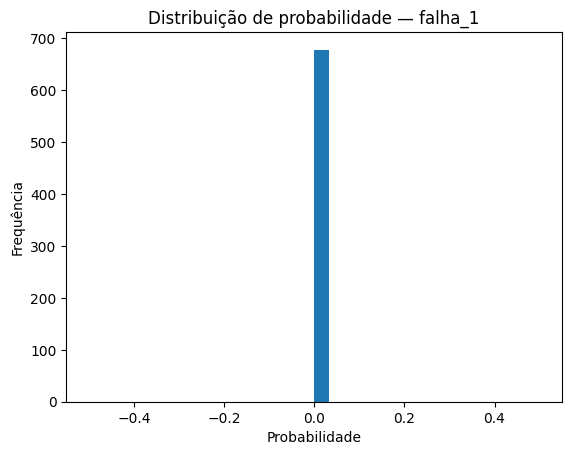

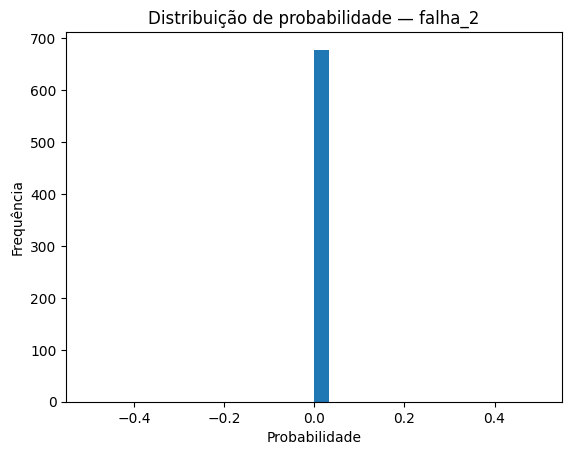

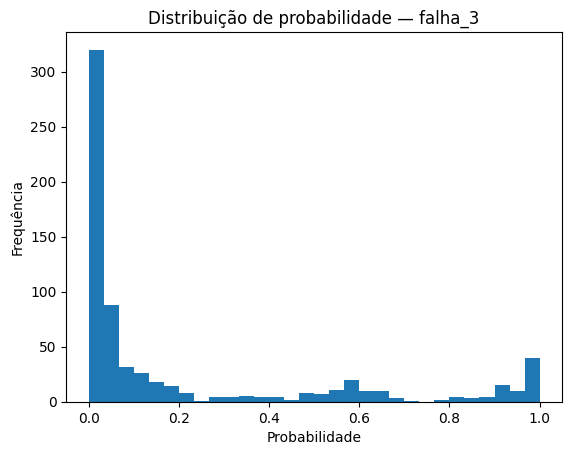

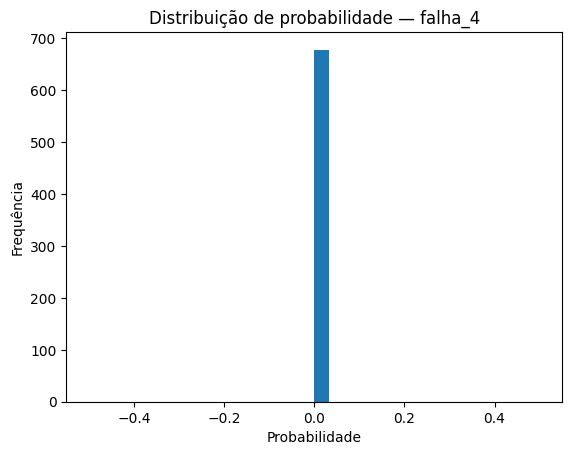

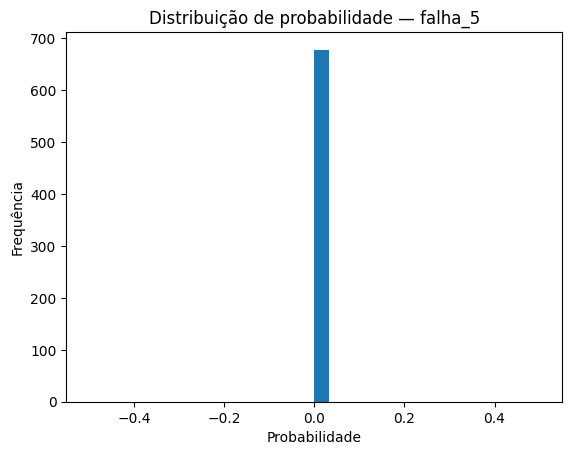

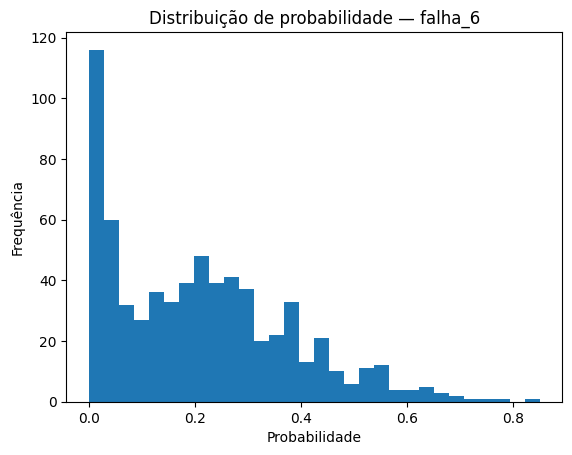

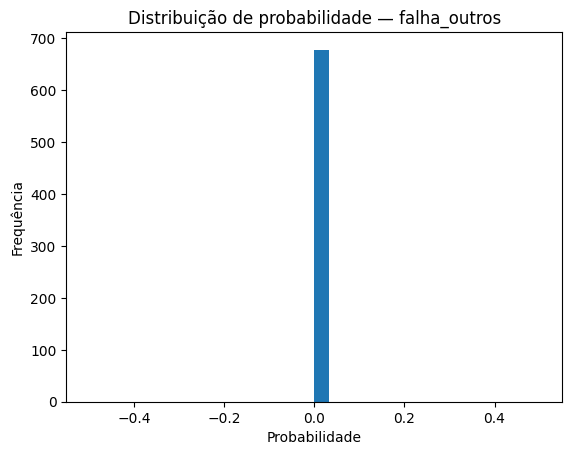

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, hamming_loss
import matplotlib.pyplot as plt

# 1) Predições e binarização com threshold 0.5
y_proba_val = clf.predict_proba(X_val)
y_pred_val  = (y_proba_val >= 0.5).astype(int)

# 2) Relatório de classificação
print(classification_report(y_val, y_pred_val, target_names=target_cols))

# 3) ROC AUC (macro e por classe)
print("ROC AUC (macro):", roc_auc_score(y_val, y_proba_val, average='macro'))
for i, col in enumerate(target_cols):
    print(f"ROC AUC {col}: {roc_auc_score(y_val[col], y_proba_val[:,i]):.3f}")

# 4) Hamming Loss
print("Hamming Loss:", hamming_loss(y_val, y_pred_val))

# 5) Histogramas de probabilidade
for i, col in enumerate(target_cols):
    plt.figure()
    plt.hist(y_proba_val[:,i], bins=30)
    plt.title(f"Distribuição de probabilidade — {col}")
    plt.xlabel("Probabilidade")
    plt.ylabel("Frequência")
    plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

best_thresholds = {}

for i, col in enumerate(['falha_3','falha_6']):
    y_true = y_val[col]
    y_score = y_proba_val[:, target_cols.index(col)]


    precisions, recalls, thresholds = precision_recall_curve(y_true, y_score)

    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    # Escolhe o threshold que maximiza F1
    best_idx = np.nanargmax(f1s)
    best_thresh = thresholds[best_idx]

    best_thresholds[col] = best_thresh
    print(f"{col}: melhor threshold = {best_thresh:.3f} → F1 = {f1s[best_idx]:.3f}")

print("\nThresholds finais:", best_thresholds)


falha_3: melhor threshold = 0.300 → F1 = 0.931
falha_6: melhor threshold = 0.250 → F1 = 0.552

Thresholds finais: {'falha_3': np.float64(0.3), 'falha_6': np.float64(0.25)}


In [ ]:
import numpy as np
import pandas as pd

# 1) Obter probabilidades no conjunto de teste
test_proba = clf.predict_proba(X_test_scaled)

# 2) Inicializar predições binárias com zeros
y_pred_test = np.zeros_like(test_proba, dtype=int)

# 3) Aplicar thresholds específicos
for i, col in enumerate(target_cols):
    thresh = best_thresholds.get(col, 0.5)  # usa 0.5 para as classes sem ajuste
    y_pred_test[:, i] = (test_proba[:, i] >= thresh).astype(int)

# 4) Montar DataFrame de submissão
submission = pd.DataFrame(y_pred_test, columns=target_cols)
submission.insert(0, 'id', df_test['id'])

# 5) Salvar CSV
submission.to_csv('submission_adjusted.csv', index=False)
print("✅ 'submission_adjusted.csv' criado com thresholds ajustados para falha_3 e falha_6.")


✅ 'submission_adjusted.csv' criado com thresholds ajustados para falha_3 e falha_6.


In [ ]:
!pip install iterative-stratification


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np


2) Configurar o cross-validation

In [ ]:
# Parâmetros
n_splits = 5
mlkf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Containers para métricas
f1_scores = {col: [] for col in target_cols}
roc_auc_scores = {col: [] for col in target_cols}

# Features e labels já preparados:
X_all = X_scaled       # de antes, todo o X
y_all = df_train[target_cols].values

# Loop pelos folds
for fold, (train_idx, val_idx) in enumerate(mlkf.split(X_all, y_all), 1):
    X_tr, X_va = X_all[train_idx], X_all[val_idx]
    y_tr, y_va = y_all[train_idx], y_all[val_idx]

    # Treina o mesmo classificador
    clf_fold = OneVsRestClassifier(
        RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    )
    clf_fold.fit(X_tr, y_tr)

    # Probabilidades e predições com thresholds já ajustados
    proba_va = clf_fold.predict_proba(X_va)
    pred_va  = np.zeros_like(proba_va, dtype=int)
    for i, col in enumerate(target_cols):
        thresh = best_thresholds.get(col, 0.5)
        pred_va[:,i] = (proba_va[:,i] >= thresh).astype(int)

    # Calcula métricas por classe
    for i, col in enumerate(target_cols):
        # F1 — cuidado com labels sem variação
        if np.unique(y_va[:,i]).size > 1:
            f1 = f1_score(y_va[:,i], pred_va[:,i])
            auc = roc_auc_score(y_va[:,i], proba_va[:,i])
        else:
            f1, auc = np.nan, np.nan
        f1_scores[col].append(f1)
        roc_auc_scores[col].append(auc)

    print(f"Fold {fold} concluído.")


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  

Fold 1 concluído.


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


Fold 2 concluído.


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


Fold 3 concluído.


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(


Fold 4 concluído.


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(


Fold 5 concluído.


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(


In [ ]:
for col in target_cols:
    f1_mean = np.nanmean(f1_scores[col])
    auc_mean = np.nanmean(roc_auc_scores[col])
    print(f"{col}:  F1 média = {f1_mean:.3f},  ROC AUC média = {auc_mean:.3f}")


falha_1:  F1 média = nan,  ROC AUC média = nan
falha_2:  F1 média = nan,  ROC AUC média = nan
falha_3:  F1 média = 0.921,  ROC AUC média = 0.985
falha_4:  F1 média = nan,  ROC AUC média = nan
falha_5:  F1 média = nan,  ROC AUC média = nan
falha_6:  F1 média = 0.538,  ROC AUC média = 0.807
falha_outros:  F1 média = nan,  ROC AUC média = nan


<ipython-input-31-e00f8950d052>:2: RuntimeWarning: Mean of empty slice
  f1_mean = np.nanmean(f1_scores[col])
<ipython-input-31-e00f8950d052>:3: RuntimeWarning: Mean of empty slice
  auc_mean = np.nanmean(roc_auc_scores[col])


Testar um modelo mais robusto (LightGBM)

In [ ]:

!pip install lightgbm

# 2) Importe e ajuste o loop de CV:
from lightgbm import LGBMClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

n_splits = 5
mlkf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores_lgb = {col: [] for col in target_cols}
roc_auc_scores_lgb = {col: [] for col in target_cols}

for fold, (train_idx, val_idx) in enumerate(mlkf.split(X_all, y_all), 1):
    X_tr, X_va = X_all[train_idx], X_all[val_idx]
    y_tr, y_va = y_all[train_idx], y_all[val_idx]

    clf_lgb = OneVsRestClassifier(
        LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    )
    clf_lgb.fit(X_tr, y_tr)

    proba_va = clf_lgb.predict_proba(X_va)
    pred_va  = np.zeros_like(proba_va, dtype=int)
    for i, col in enumerate(target_cols):
        thresh = best_thresholds.get(col, 0.5)
        pred_va[:,i] = (proba_va[:,i] >= thresh).astype(int)

    for i, col in enumerate(target_cols):
        if np.unique(y_va[:,i]).size > 1:
            f1_scores_lgb[col].append(f1_score(y_va[:,i], pred_va[:,i]))
            roc_auc_scores_lgb[col].append(roc_auc_score(y_va[:,i], proba_va[:,i]))
        else:
            f1_scores_lgb[col].append(np.nan)
            roc_auc_scores_lgb[col].append(np.nan)
    print(f"Fold {fold} (LGB) concluído.")

# 3) Resumo
for col in target_cols:
    print(f"{col}: LGB F1 = {np.nanmean(f1_scores_lgb[col]):.3f}, ROC AUC = {np.nanmean(roc_auc_scores_lgb[col]):.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5167
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Fold 1 (LGB) concluído.
[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5178
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 645, number of negative: 2067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5178
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Fold 2 (LGB) concluído.
[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5178
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 645, number of negative: 2067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5178
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 1 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Fold 3 (LGB) concluído.
[LightGBM] [Info] Number of positive: 520, number of negative: 2192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5191
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Fold 4 (LGB) concluído.
[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5186
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 (LGB) concluído.
falha_1: LGB F1 = nan, ROC AUC = nan
falha_2: LGB F1 = nan, ROC AUC = nan
falha_3: LGB F1 = 0.923, ROC AUC = 0.986
falha_4: LGB F1 = nan, ROC AUC = nan
falha_5: LGB F1 = nan, ROC AUC = nan
falha_6: LGB F1 = 0.563, ROC AUC = 0.810
falha_outros: LGB F1 = nan, ROC AUC = nan


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-32-126f171e39f0>:42: RuntimeWarning: Mean of empty slice
  print(f"{col}: LGB F1 = {np.nanmean(f1_scores_lgb[col]):.3f}, ROC AUC = {np.nanmean(roc_auc_scores_lgb[col]):.3f}")


In [ ]:
!pip install imbalanced-learn
!pip install imbalanced-learn --upgrade


In [ ]:
!pip install --upgrade imbalanced-learn


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=False)


import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Carregue os dados
data_path = '/content/drive/MyDrive/trabalho/'  # ajuste conforme seu Drive
df_train = pd.read_csv(data_path + 'bootcamp_train.csv')
df_test  = pd.read_csv(data_path + 'bootcamp_test.csv')

# mapeie os targets para 0/1
target_cols = [
    'falha_1','falha_2','falha_3',
    'falha_4','falha_5','falha_6','falha_outros'
]
for col in target_cols:
    df_train[col] = (
        df_train[col].astype(str).str.lower()
                       .map({'true':1,'false':0,'sim':1,'não':0,'nao':0})
                       .fillna(0).astype(int)
    )

#  Seleção de features numéricas
X       = df_train.drop(columns=['id'] + target_cols).select_dtypes(include=[np.number])
X_test0 = df_test .drop(columns=['id']).select_dtypes(include=[np.number])

# Alinhe colunas de X_test a X (mesmas colunas e ordem)
X_test = X_test0.reindex(columns=X.columns, fill_value=np.nan)

# Imputação de valores ausentes (mediana)
imp = SimpleImputer(strategy='median')
X_imp       = imp.fit_transform(X)
X_test_imp  = imp.transform(X_test)

#  Escalonamento (StandardScaler)
scaler       = StandardScaler()
X_scaled     = scaler.fit_transform(X_imp)
X_test_scaled= scaler.transform(X_test_imp)

# Prepare X_all e y_all para CV ou modelagem
X_all = X_scaled
y_all = df_train[target_cols].values

print("Preparação concluída:")
print(" X_all.shape     =", X_all.shape)
print(" X_test_scaled.shape =", X_test_scaled.shape)
print(" y_all.shape     =", y_all.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preparação concluída:
 X_all.shape     = (3390, 26)
 X_test_scaled.shape = (389, 26)
 y_all.shape     = (3390, 7)


In [ ]:
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score

# thresholds já definidos
best_thresholds = {'falha_3': 0.3, 'falha_6': 0.25}

# Configuração do CV
mlkf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Containers para armazenar métricas
f1_scores_os  = {c: [] for c in target_cols}
auc_scores_os = {c: [] for c in target_cols}

#  Função de oversampling manual
def oversample_multilabel(X, y, min_count=100):
    X_res, y_res = X.copy(), y.copy()
    for i in range(y.shape[1]):
        pos_idx = np.where(y[:,i] == 1)[0]
        n_pos = len(pos_idx)
        if 0 < n_pos < min_count:
            reps = (min_count // n_pos) - 1
            X_res = np.vstack([X_res] + [X[pos_idx]] * reps)
            y_res = np.vstack([y_res] + [y[pos_idx]] * reps)
    return X_res, y_res

#  Loop de CV com oversampling
for fold, (tr_idx, va_idx) in enumerate(mlkf.split(X_all, y_all), 1):
    X_tr, X_va = X_all[tr_idx], X_all[va_idx]
    y_tr, y_va = y_all[tr_idx], y_all[va_idx]

    # 4.1) Oversample manual no treino
    X_res, y_res = oversample_multilabel(X_tr, y_tr, min_count=100)

    # 4.2) Treinamento LightGBM multilabel
    clf_os = OneVsRestClassifier(
        LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    )
    clf_os.fit(X_res, y_res)

    #  Avaliação no fold
    proba_va = clf_os.predict_proba(X_va)
    pred_va  = np.zeros_like(proba_va, dtype=int)
    for i, col in enumerate(target_cols):
        thr = best_thresholds.get(col, 0.5)
        pred_va[:,i] = (proba_va[:,i] >= thr).astype(int)

    # Coleta métricas por classe
    for i, col in enumerate(target_cols):
        if np.unique(y_va[:,i]).size > 1:
            f1_scores_os[col].append(f1_score(y_va[:,i], pred_va[:,i]))
            auc_scores_os[col].append(roc_auc_score(y_va[:,i], proba_va[:,i]))
        else:
            f1_scores_os[col].append(np.nan)
            auc_scores_os[col].append(np.nan)

    print(f"Fold {fold} concluído.")

#  Resumo das métricas médias
print("\n=== Métricas médias com Oversampling Manual ===")
for col in target_cols:
    f1_mean  = np.nanmean(f1_scores_os[col])
    auc_mean = np.nanmean(auc_scores_os[col])
    print(f"{col}:  F1 média = {f1_mean:.3f},  ROC AUC média = {auc_mean:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 212, number of negative: 2500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199, number of negative: 2513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 77, number of negative: 2635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 947, number of negative: 1765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Fold 1 concluído.
[LightGBM] [Info] Number of positive: 212, number of negative: 2500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 200, number of negative: 2512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 76, number of negative: 2636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 947, number of negative: 1765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Fold 2 concluído.
[LightGBM] [Info] Number of positive: 212, number of negative: 2500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5192
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199, number of negative: 2513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5192
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5192
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 948, number of negative: 1764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5192
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Fold 3 concluído.
[LightGBM] [Info] Number of positive: 212, number of negative: 2500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199, number of negative: 2513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 519, number of negative: 2193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 947, number of negative: 1765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Fold 4 concluído.
[LightGBM] [Info] Number of positive: 212, number of negative: 2500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5183
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199, number of negative: 2513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5183
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 520, number of negative: 2192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5183
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 947, number of negative: 1765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5183
[LightGBM] [Info] Number of data points in the train set: 2712, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Fold 5 concluído.

=== Métricas médias com Oversampling Manual ===
falha_1:  F1 média = 0.324,  ROC AUC média = 0.867
falha_2:  F1 média = 0.681,  ROC AUC média = 0.962
falha_3:  F1 média = 0.931,  ROC AUC média = 0.987
falha_4:  F1 média = 0.783,  ROC AUC média = 0.992
falha_5:  F1 média = 0.412,  ROC AUC média = 0.904
falha_6:  F1 média = 0.571,  ROC AUC média = 0.813
falha_outros:  F1 média = 0.548,  ROC AUC média = 0.753


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

In [ ]:
import numpy as np
import pandas as pd
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

# 1) Treinar em tudo
clf_final = OneVsRestClassifier(
    LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42)
)
clf_final.fit(X_all, y_all)

# 2) Prever probabilidades no teste
proba_test = clf_final.predict_proba(X_test_scaled)

# 3) Aplicar thresholds
pred_test = np.zeros_like(proba_test, dtype=int)
for i, col in enumerate(target_cols):
    thr = best_thresholds.get(col, 0.5)
    pred_test[:,i] = (proba_test[:,i] >= thr).astype(int)

# 4) Montar DataFrame de submissão
submission = pd.DataFrame(
    data=pred_test,
    columns=target_cols
)
submission.insert(0, 'id', df_test['id'])

# 5) Salvar CSV
output_path = '/content/drive/MyDrive/trabalho/submission.csv'
submission.to_csv(output_path, index=False)
print(f"✅ Submission salva em: {output_path}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 265, number of negative: 3125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 249, number of negative: 3141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 649, number of negative: 2741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 112, number of negative: 3278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 96, number of negative: 3294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1184, number of negative: 2206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 3390, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

✅ Submission salva em: /content/drive/MyDrive/trabalho/submission.csv


endpoint HTTP

In [ ]:
pip install requests


In [ ]:
import requests


In [ ]:
# 1) “files” é um dicionário onde a chave (aqui 'file')

files = {'file': open('/content/drive/MyDrive/trabalho/submission.csv', 'rb')}


In [ ]:

url = 'https://avaliacao.siderurgia.com/submit'


Autenticação (opcional)

In [ ]:
headers = {
    'Authorization': 'Bearer SEU_TOKEN_AQUI'
}


In [ ]:
import requests

# 1) Garanta que o submission.csv já existe
df_submission.to_csv('/content/drive/MyDrive/trabalho/submission.csv', index=False)


files = {'file': open('/content/drive/MyDrive/trabalho/submission.csv', 'rb')}


url = 'https://avaliacao.senai.br/bootcamp/evaluate'


headers = {
  'Authorization': 'Bearer SEU_TOKEN_REAL',
  # 'API-Key': 'SEU_API_KEY',  # ou outro formato
}


resp = requests.post(url, files=files, headers=headers)


print(f"Status: {resp.status_code}")
print(resp.json())  # deve vir algo como {'f1_macro': ..., 'roc_auc_macro': ..., ...}
